<img src="images/gtc-training-dli-logo-407-u.png" alt="DLI-logo" width="450" height="450" align="center"/> 

# Training Deep Reinforcement Learning Agents to Play Starcraft II 

Welcome to the lab! Before we get started here are a few pointers on jupyter notebooks.

1. This Jupyter Notebook is being rendered on your browser, but the contents are being streamed by an interactive iPython kernel running on an AWS EC2 GPU enabled instance.

2. The notebook is composed of cells; cells can contain code which you can run, or they can hold text and/or images which are there for you to read.

3. You can execute code cells by clicking the ```Run``` icon in the menu, or via the following keyboard shortcuts ```Shift-Enter``` (run and advance) or ```Ctrl-Enter``` (run and stay in the current cell).

4. To interrupt cell execution, click the ```Stop``` button on the toolbar or navigate to the ```Kernel``` menu, and select ```Interrupt ```.

I'm a markdown cell -- if you run me I'll turn into static text.

In [1]:
1 + 1  # i'm a code cell -- if you run me I'll perform some computations and show you their result below

2

# Reinforcement Learning (RL)

Reinforcement Learning is a sub-field of Machine Learning in which the learning agent does not start with a labeled dataset of examples, but instead it builds its own dataset of experiences by interacting with the environment. Initially the agent's action are random, but as the agent stumbles onto good behaviors it is rewarded by the environment and this signal allows the agent to update its parameters so as to maximize the collection of future rewards.

<img src="images/RL.jpg" width="95%"></img>

RL has recently gained a lot of popularity since Google's DeepMind used RL and deep learning (DL) to train AI agents that can master Atari games by learning how to play the game from pixels alone.  Since then, DeepMind has used deep reinforcement learning (DRL) to beat Go.

The next great unsolved challenge in RL is StarCraft II -- <a href="https://deepmind.com/blog/deepmind-and-blizzard-open-starcraft-ii-ai-research-environment/">read more</a>!

# StarCraft II
StarCraft II (SC2) is a real-time strategy game developed by Blizzard that is free to play (<a href='https://starcraft2.com/en-us/'>link to official game site</a>). 
Click the image to watch an overview video.

<a href='https://www.youtube.com/watch?v=yaqeZ9Snt4E'> <img src="images/sc2.jpg"></img> </a>
    
Real-Time Strategy games require many skills including: strategic thinking, accurate/fast execution, information gathering/hiding, and economic resource management. In this lab we'll be training neural network agents to playing mini-games which isolate and capture some of the basic skills of the full game. 

<a href=""><img src="https://storage.googleapis.com/deepmind-live-cms-alt/documents/mini-games.gif" width="90%"></a>

# Lab Sections

This lab is composed of the following sections:

    
<ul>
    <a href='#section1'>Section#1</a> Programmatically explore and control SC2 using DeepMind's Pysc2 API
    <br>&nbsp;<br>
    <a href='#section2'>Section#2</a> Learn about how rewards can be used to shape agent behavior
    <br>&nbsp;<br>
    <a href='#section3'>Section#3</a> Tracking the Learning Process
    <br>&nbsp;<br>
    <a href='#section4'>Section#4</a> [ Mix & Match ] Deploy a trained agent in its target map or a new/foreign setting 
    <br>&nbsp;<br>
    <a href='#section5'>Section#5</a> Build/Modify your own deep learning SC2 agent in Keras (TensorFlow backend)
</ul>

In [2]:
import warnings; warnings.filterwarnings("ignore") # supress warnings

<a id='section1'></a>
# Section1 -- The SC2 PyGame Client and the Python API

Working collaboratively with Blizzard, DeepMind have released a high level Python API ( <a href="https://github.com/deepmind/pysc2">pysc2</a> ) which we can use to build machine learning agents that interact with the StarCraft II engine. 

Let's load this library into our notebook with the following import command:

In [3]:
import pysc2

Next, try using pysc2 to launch a mini-game using the py-game rendering client which produces a low-resolution view of the game (this view is what our deep learning agent will be using to play).

The mini-game we'll be loading up will allow us to use the mouse and keyboard to control a squad of 9 Terran Space <a href="http://us.battle.net/sc2/en/game/unit/marine">Marines</a> squaring up against a set of 4 Zerg <a href="http://us.battle.net/sc2/en/game/unit/roach">Roaches</a>.

By running the command below you'll launch the sc2 py-game client loaded with the "DefeatRoaches" map. 



In [18]:
python -m pysc2/bin/play --map DefeatRoaches --max_game_steps 2000 > /dev/null 2>&1

SyntaxError: invalid syntax (<ipython-input-18-471f3d563737>, line 1)

To view and play on this map we will need to open another tab which will be running a remote graphical desktop connection with the instance hosting the lab in the AWS cloud.


### <center>Click on [noVNC Server](http://dli-9624cfae103e-courses-nvidia-com-user-32173-e0e69a.westus2.cloudapp.azure.com:6900/?password=vncpassword) to see the Pysc2 client. </center>

Next let's launch the game client which should show up in the VNC viewer. Note that after 600 game steps the mini-game will close and you'll be able to restart it (by re-running the cell or continue with the rest of the content). NOTE: Use Internet Explorer or Microsoft Edge as you may not be able to interact with the game in other browsers.

You should now be able to select and interact with the game in the GUI that is displayed within the VNC viewer. Click and drag to select (the green marine circles) and right click on the spot you would like the selected units to move to.


<img src="images/marine_vs_roach.jpg" width="50%"></img><img src="images/marine_vs_roach_in_game.jpg" width="50%"></img>

If you're curious you can try other mini-games by replacing DefeatRoaches in the cell above with one of the other map names. Here are some mini-games you can launch.

* CollectMineralShards
* DefeatZerglingsAndBanelings
* FindAndDefeatZerglings
* MoveToBeacon

Each minigame attempts to teach the AI a different skill needed to master SC2.  What skills must the agent learn to master DefeatRoaches?

<b> FAQ:</b> Some browsers do not allow for interactive play within the VNC session -- try switching browsers or disabling extensions.

## 1.2 -- Exploring Environment Observations Programmatically

Next we'll learn how to create and interact with SC2 environments programmatically. Instead of directly using the mouse and keyboard we'll use the functional API to explore the observations produced by the SC2 py-game client as well as to issue commands.

<img src="images/sc2_RL_environment.png" style="height:350px">

In [6]:
import numpy as np
import matplotlib.pylab as plt

# required 
from absl import flags
FLAGS = flags.FLAGS
FLAGS(['--'])

# note this import must happen after flag initialization
from pysc2.env import sc2_env
from pysc2.lib import actions
from pysc2.lib import features

# define environment flags
env_args = dict(
        map_name='DefeatRoaches',
        step_mul=1, # How many time steps occur between each action-decision. A step_mul of 1 means an agent can choose one action per frame.
        game_steps_per_episode=0, # no limit- but each map has a built-in max number of steps and will terminate after reaching that.
        screen_size_px = ( 64, 64 ), 
        minimap_size_px = ( 32, 32 ),
        visualize = True,
        score_index = None
)

In [7]:
# spawn the environment -- may take a minute to launch
env = sc2_env.SC2Env(**env_args) # ** syntax implies variable number named arguments
obs = env.reset()




Pysc2 can be used from Linux, Windows, or MacOS.  We'll be using Linux instances for this lab but the replays from agents can be downloaded and then viewed on your Windows or Mac machine later.  

We can now inspect a sample raw observation which the sc2 Linux simulator makes available after each game step.

In [8]:
obs[0]

TimeStep(step_type=<StepType.FIRST: 0>, reward=0, discount=1.0, observation={'cargo': array([], shape=(0, 7), dtype=int32), 'minimap': array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],



There are lots of interesting data elements in the observation. If you look carefully you should be able to find the reward information for the current timestep, the cumulative score, as well as many other details about the state of the world including the available actions. Since we've just entered a new game world many of these values do not have a particularly informative state, however we'll come back to them again a bit later once we've taken some actions. Here we just demonstrate how their values can be accessed.

In [9]:
print( 'current reward: ', obs[0].reward )
print( 'cumulative score: ', obs[0].observation['score_cumulative'][0])
print( 'available data elements: ', obs[0].observation.keys())

('current reward: ', 0)
('cumulative score: ', 0)
('available data elements: ', ['cargo', 'minimap', 'game_loop', 'available_actions', 'screen', 'control_groups', 'multi_select', 'cargo_slots_available', 'player', 'single_select', 'build_queue', 'score_cumulative'])


Let's specifically look at just the screen's visual layers. 

These visual "feature layers" represent elements of the game such as unit type, unit owner (player 1 vs player 2), unit health and other important aspects of the game state. Each feature layer is provided as a separate input to the network but since they all share the same spatial reference frame, they can be thought of as different channels/dimensions that come together to form a complete representation of the game state (i.e., similar to how the Red, Green, and Blue color channels are represented in photographs)

<img src="images/feature_layers.png" style="height:350px">
<center>
**Note, this is a visualization of a very active screen in the middle of a late-game battle. We won't be seeing such a complex scene while playing mini-games.*
</center>


First we'll visualize all the data channels and their names.

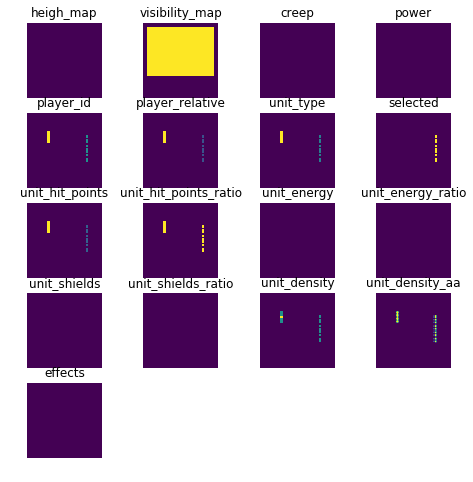

In [10]:
numScreenLayers = obs[0].observation['screen'].shape[0] # 17

plt.figure(figsize=(8,8))
titles = ['heigh_map', 'visibility_map', 'creep', 'power', 'player_id', 
          'player_relative', 'unit_type', 'selected', 
          'unit_hit_points', 'unit_hit_points_ratio', 
          'unit_energy', 'unit_energy_ratio', 
          'unit_shields', 'unit_shields_ratio', 
          'unit_density', 'unit_density_aa', 'effects']
[ [plt.subplot(5, 4, iScreenLayer+1), plt.imshow( obs[0].observation['screen'][iScreenLayer], aspect='equal'), 
       plt.title(titles[iScreenLayer]), plt.axis('off')] 
 for iScreenLayer in range(numScreenLayers) ]

plt.show()

Now we can zoom in on a single of these, to see it in more detail. Try changing the screen index and re-running the cell below. A description of what all the layers mean can be found <a href='https://github.com/deepmind/pysc2/blob/master/docs/environment.md#feature-layers'>at the following link</a>.

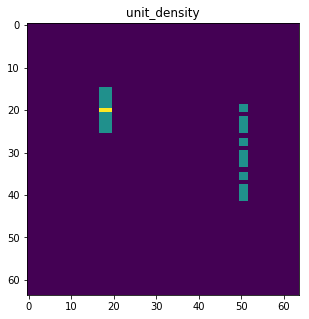

In [14]:
screenIndex = 14 # choose a number between 0 and 16
plt.figure(figsize=(5,5))
plt.imshow( obs[0].observation['screen'][screenIndex])
plt.title(titles[screenIndex])
plt.show()

## 1.3 -- Taking Actions with the API

Now that we've explored the observations produced by the sc2 engine. Let's try to take some actions that we can send to the engine so that it can respond and generate the next step/observation. 

The python functional API for taking actions in StarCraft enables us to produce the entire set of actions available to human players interacting through the mouse and keyboard. 

Let's see what actions are currently available to our agent.

In [15]:
for iAction in obs[0].observation['available_actions']:
    print( actions.FUNCTIONS[iAction] )

0/no_op ()
1/move_camera (1/minimap [0, 0])
2/select_point (6/select_point_act [4]; 0/screen [0, 0])
3/select_rect (7/select_add [2]; 0/screen [0, 0]; 2/screen2 [0, 0])
4/select_control_group (4/control_group_act [5]; 5/control_group_id [10])
5/select_unit (8/select_unit_act [4]; 9/select_unit_id [500])
7/select_army (7/select_add [2])
12/Attack_screen (3/queued [2]; 0/screen [0, 0])
331/Move_screen (3/queued [2]; 0/screen [0, 0])
332/Move_minimap (3/queued [2]; 1/minimap [0, 0])
333/Patrol_screen (3/queued [2]; 0/screen [0, 0])
334/Patrol_minimap (3/queued [2]; 1/minimap [0, 0])
13/Attack_minimap (3/queued [2]; 1/minimap [0, 0])
274/HoldPosition_quick (3/queued [2])
451/Smart_screen (3/queued [2]; 0/screen [0, 0])
452/Smart_minimap (3/queued [2]; 1/minimap [0, 0])
453/Stop_quick (3/queued [2])


In order to see how we can translate between a sequence of mouse and keyboard actions to functional API calls the following animated graphic is helpful.

<img src="https://storage.googleapis.com/deepmind-live-cms-alt/documents/Oriol-Fig-Anim-170809-Optimised-r03.gif"></img>

Below are several example actions that we can issue using the functional API.

In [21]:
# do nothing
doNothing = actions.FunctionCall( 0, [] ) 

# rectangle select and add to existing selection, rectangle from (0,0) to (31, 31)
selectRectangle = actions.FunctionCall(3, [[1], [0,0], [31,31]])

# select entire army
selectEntireArmy = actions.FunctionCall(7, [[1]])

Next let's select all of our available army units and make them attack a point on the screen (and lets re-issue this order for the next 100 game steps).

In [28]:
# attack screen location ( x=60, y=15 ) -- assumes a mini-game with at least 64x64 tiles
attackScreen = actions.FunctionCall(12, [[0], [60, 15]])

obs = env.step( [ selectEntireArmy ] )
for i in range(100):
    obs = env.step( [ attackScreen ] )

## 1.4 -- [Optional] Action Types & Build Your Own Actions

This section aims to provide additional detail about programmatic actions in SC2. Each action has a specific structure depending on whether it requires a modifier and/or spatial arguments. 

Below are several common possible action signatures (not an exhaustive list):

```
Type1: action.FunctionCall( functionID )
Type2: action.FunctionCall( functionID, [ [ modifier ] ] ) # e.g., 'select_army'
Type3: action.FunctionCall( functionID, [ [ modifier ], [x1, y1 ] ) # e.g., 'attack_screen'
Type4: action.FunctionCall( functionID, [ [ modifier ], [x1, y1], [x2, y2] ) # e.g., 'select_rect'
```
<b>Type1</b> are simple actions such as 'Stop_quick' (ID: 453) or 'HoldPosition_quick' (ID: 274) which do not require any modifiers or screen coordinates. 

<b>Type2</b> actions require a modifier -- in the case of 'select_army' (ID: 7) [which selects all living army units] the modifier  indicates whether the returned army unit set should be added to whatever is currently selected (e.g., a worker unit) or replace the existing selection. 

<b>Type3</b> actions require a modifier and a single coordinate -- e.g., 'Attack_screen' (ID: 12), has a modifier that indicates whether the action should be done immediately (or added to a queue for execution) as well as a single coordinate target.

<b>Type4</b> actions require a modifier and two screen coordinates -- e.g., 'select_rect' (ID: 3) which require both a modifier (whether to replace, concatenate, or subtract the new selection from the existing selection) as well as two screen coordinates indicating the bounding box that defines the new selection. 

Our RL agents can only interact with the game world using this programmatic interface -- can you try to create an interesting sequence of actions below?

<b>Helpful Hints:</b> If you need to, feel free to <b>reset</b> the game state to the beginning with the following command ```obs = env.reset()```
We've also written a ```safe_action``` function (a few cells below) that you can your can use to help avoid actions that are not permitted.


In [32]:
# add your code here
obs = env.reset()
obs = env.step( [ selectEntireArmy ] )

## 1.5 -- Random Actions

Below we've written the code for an agent that randomly chooses points to attack. You may notice that even the random agent can stumble onto good behaviors and in fact this is what we rely on to bootstrap the learning process when we initially randomly initialize the parameters of our agents.

In [33]:
"""
If the action we chose can't be executed lets try to select our entire army, 
advance the game state, and try again.
"""

def safe_action ( actionToTake, obs ):
    if actionToTake.function not in obs.observation['available_actions']:
        print('unable to take selected action...lets try to fix things')
        print('fix#1: select all army units')
        obs = env.step( [ selectEntireArmy ] )
        print('fix#2: perform no-op action')
        obs = env.step( [ doNothing ] )
        if actionToTake.function not in obs[0].observation['available_actions']:
            print('!we are really in trouble...consider taking a different action')
    else:
        obs = env.step( [ actionToTake ] )
    return obs

In [37]:
# obs = env.reset()
nCycles = 1000
for iCycles in range ( nCycles ):    
    randomAttackScreen = actions.FunctionCall( 12, [[0], [np.random.randint(63), np.random.randint(63)]])
    obs = safe_action ( randomAttackScreen, obs[0] )

unable to take selected action...lets try to fix things
fix#1: select all army units
fix#2: perform no-op action
unable to take selected action...lets try to fix things
fix#1: select all army units
fix#2: perform no-op action


<a id='section2'></a>
# Section 2 -- Reward Shaping

Agents trained by DRL can learn behaviors depending on the environment (simulator) that they train in and also the rewards that the environment gives them.  We trained two agents in the same environment, a simple minimap with two roach packs split apart.  

## 2.1 -- Specifying Rewards Through the SC2 Map Editor
We used the map-editor to change the logic which governs the reward generated by the environment. If you'd like to build your own mini-games or modify existing ones, download and install the free to play Starcraft client which includes the map-editor. You can then edit maps by modifying the terrain and/or adjusting the logic in the triggers. Below is a screenshot from the logic of the default DefeatRoaches map which increases the score by 10 every time a roach is killed (just for reference: player one is our RL agent and player two is the in-game scripted AI).

<img src="images/map_editor.jpg"></img>

## 2.2 -- Reward Modifications and Emergent Behaviors

Using the SC2 Map Editor we built several variations of the DefeatRoaches Map. In one case we encouraged the agent to be aggressive by giving a penalty for every elapsed second. Execute the cell below to see a recording of this agent after it was trained for an extended duration. Notice that the above agent is always on the move and is always looking for enemies to kill.  The agent can get a higher score by finding and killing all of the roaches more quickly.

In [38]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/8eRFzXtBdwA?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

Next we built a map that more heavily penalized the loss of squad members. Execute the cell below to see this conservative agent in action.

In [39]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/9Opgktl6kLo?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

While the aggressive agent is always on the move and looking for roaches to kill, the conservative agent is more than happy to hang out in the corner and not lose any marines.

<a id='section3'></a>
# Section 3 -- Tracking the Learning Process

We can understand a lot about our agents by looking at the rewards that they are able to earn over time.  By plotting these curves with respect to time training or number of frames seen, we get a reward curve.  We've plotted our curves using Tensorboard from Tensorflow.  You can inspect the curves for a number of different agents at this [link](/tensorboard/).

Click "toggle all runs" then click on the run you want to explore.  Many metrics are captured sc2/episode_score has the score that the agent was given from the environment.

The agents were trained using this open source repo: https://github.com/simonmeister/pysc2-rl-agents.git Here's an image of a reward curve for an agent training in the DefeatRoaches minigame.
<center>
<img src="images/DefeatRoaches.PNG" width="75%"></img>
</center>
As you can see from the learning curve, often times the agent has to sacrifice its score in order to learn a new strategy that will ultimately lead to better play.  Here are two videos.  The first is the agent half-way through its training and the second is the agent when fully trained.

## 3.1 -- Half-Trained

In [40]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/tzPrtTXPTEA?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

Notice that the agent has learned to focus down the roaches some.  However, it's still learning and spends some time clicking around the map. 

By the end of the training, the agent is very efficient and focuses down the roaches with ease.  With some luck, the agent can score very high!

In [41]:
%%HTML
<center><iframe width="560" height="315" src="https://www.youtube.com/embed/IBUgp6097Q0?rel=0" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe></center>

## 3.2 -- Multiple Environments

By having your agent play in multiple environments simultaneously, the agent can learn much faster.  We trained one agent using 16 environments simultaneously and another agent using only one environment.


<img src="images/MoveToBeaconNenvs.PNG" width="75%"></img>
The agent with 16 environments was able to master the MoveToBeacon minimap in 20 minutes while the agent with 1 environment took 2 hours and 20 minutes.

MoveToBeacon is a simple minigame and so an agent learning in only one environment can still master the game.  For more complex environments, agents often need to train in multiple environments in order to learn the advanced strategies required to master the game.

Browse [TensorBoard](/tensorboard/) in order to explore the reward curves more.  TensorBoard also has the reward curve for an agent that trained on 8 envs simultaneously.

<a id='section4'></a>
# Section 4 -- Mix and Match Agents and Environments

In this section, you can choose an agent and then have that agent play in a mini-game.  You're free to experiment and see how different agents do in different environments. Below is a list of the available agents and the environments you can deploy them to.

### Available Agents 

* <b>DefeatRoaches</b> -- fully trained agent on the DefeatRoaches map
* <b>DefeatRoaches_half_trained</b> -- partially trained agent on the DefeatRoaches map
* <b>DefeatRoaches_singleRoundReset_conserveMarines_noTimePenalty_splitRoachPacks</b> -- agent tries hard not to lose units
* <b>DefeatRoaches_singleRoundReset_highTimePenalty_splitRoachPacks</b> -- agent has to hurry to kill opponent
* <b>MoveToBeacon_n_envs_16</b> -- agent trained to move to a target beacon

### Environments [ <a href="https://github.com/deepmind/pysc2/blob/master/docs/mini_games.md">detailed descriptions</a> ]
<ul>
BuildMarines <b>||</b> CollectMineralShards <b>||</b> CollectMineralsAndGas <br >
DefeatRoaches <b>||</b> DefeatZerglingsAndBanelings <b>||</b> FindAndDefeatZerglings <br >
MoveToBeacon
</ul>

To load an agent, we have to specify the map and the checkpoint. Put the agent's name below to see the model checkpoint number.

In [42]:
!ls /notebooks/models/DefeatRoaches

checkpoint			       model.ckpt-250000.index
model.ckpt-250000.data-00000-of-00001  model.ckpt-250000.meta


The "checkpoint" file points to the model to be loaded.

In [43]:
!echo "model_checkpoint_path: \"/notebooks/models/DefeatRoaches/model.ckpt-250000\"" > /notebooks/models/DefeatRoaches/checkpoint

The replay will be written to disk after 10 episdoes have been played.

When you are finished click the ```Stop``` button on the toolbar or navigate to the ```Kernel``` menu, and select ```Interrupt ``` so that you can execute more cells.

In [46]:
!python /notebooks/pysc2-rl-agents/run.py \
  DefeatRoaches \
  --map DefeatRoaches \
  --max_windows 1 --gpu 0 --envs 1 \
  --step_mul 8 --steps_per_batch 16 \
  --vis --eval \
  --save_dir /notebooks/models \
  --summary_dir /notebooks/summary \
  --iters 250

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
2019-03-20 21:28:59.241263: I tensorflow/core/platform/cpu_feature_guard.cc:137] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
Version: B55958 (SC2.3.16)
Build: Jul 31 2017 13:19:41
Command Line: '"/headless/StarCraftII/Versions/Base55958/SC2_x64" -listen 127.0.0.1 -port 21440 -dataDir /headless/StarCraftII/ -tempDir /tmp/sc-kz9wS_/ -displayMode 0'
Starting up...
Startup Phase 1 complete
2019-03-20 21:28:59.358961: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1030] Found device 0 with properties: 
name: Tesla K80 major: 3 minor: 7 memoryClockRate(GHz): 0.8235
pciBusID: 3433:00:00.0
totalMemory: 11.17GiB freeMemory: 11

When you're done generating replays, you can execute the cell below to zip the files.

In [47]:
!apt-get update > /dev/null 2>&1 && apt-get install zip > /dev/null 2>&1 && zip /notebooks/replays.zip /notebooks/replays/*

  adding: notebooks/replays/DefeatRoaches_2019-03-20-21-29-27.SC2Replay (deflated 12%)
  adding: notebooks/replays/DefeatRoaches_2019-03-20-21-29-44.SC2Replay (deflated 8%)
  adding: notebooks/replays/DefeatRoaches_2019-03-20-21-30-00.SC2Replay (deflated 6%)


[Click here to download your replays.](replays.zip)

To view your replays using your local client, put the replay file in ```~/StarCraftII/replays``` and and the minigames to ```~/StarCraftII/Maps/mini_games```.  You can download the minigames from [here](https://github.com/deepmind/pysc2/tree/master/pysc2/maps/mini_games).

<a id='section5'></a>
# Section 5 -- Build and Train your Own Agent

We hope you've enjoyed the lab so far and hopefully learned something new about RL & SC2. We've only barely scratched the surface of what's possible and if you'd like to go further we hope to offer some tools for additional exploration.

Below we have built a training harness for a custom agent using Keras with a TensorFlow back-end. Our goal is to offer an approachable sandbox for anyone interested in experiment with RL ideas in the SC2 context.

This code harness is structured as follows:
<ul>
1 -- Define Key Parameters <br>
2 -- Create Multiple SC2 Environments <br>
3 -- Load the Agent Code <br>
4 -- Run the Interaction Loop (using trajectories of n-steps) and Update Agent Parameters <br>
</ul>
For the technically inclined, the training harness uses n-step TD learning and can stack together sequences of observation frames in order to learn about dynamics. 

In [ ]:
%%javascript
require(["base/js/dialog"], function(dialog) {dialog.modal({title: 'Cleaning Up', body: 'We need to ensure that no other sc2 environments are active -- lets force a kernel restart', buttons: {'Kernel restart': { click: function(){ Jupyter.notebook.session.restart(); } }}});});
Jupyter.notebook.session.delete();

In [ ]:
import numpy as np
import matplotlib.pylab as plt
import os.path

# required 
from absl import flags
FLAGS = flags.FLAGS
FLAGS(['initialize FLAGS for sc2 environments'])

# note this import must happen after flag initialization
from pysc2.env import sc2_env
from pysc2.lib import actions
from pysc2.lib import features

# 5.1 - Define Parameters

In [ ]:
envParams = { 
    'simultaneousEnvironments': 4,
    'nEnvironmentsToVisualize': 4,
    'nTrajectorySteps': 16,
    'nStackedFrames': 4,
    'agentStepsPerEnvironmentStep': 4,
    
    'batchCheckpointInterval': 100,
    'experimentDirectory': '/experiments',
    'debugFlag': False,
    
    'screenResX': 64,
    'screenResY': 64,
    'screenResX_minimap': 32,
    'screenResY_minimap': 32,
    
    'screenChannelsToKeep': [ 4, 5, 6, 7, 8, 9 ], # player_ID, player_relative, unit_type, selected, unit_hit_points, unit_hit_points_ratio
    'screenChannelsRetained': 6,

    'nonSpatialInputDimensions': 12, 
    'allowedActionIDs': [ 3, 12 ], # select_rect, attack_screen
    'allowedActionIDRequiresModifier': [ 2, 1 ],            
    'allowedActionIDRequiresLocation': [ 2, 1 ],       

    'prunedActionSpaceSize': 2,
    'actionArgumentSize': 4, 

    'nonVisualInputLength': 13,
    
    'futureDiscountRate': 1,   
    'stepTypeFirst': 0,
    'stepTypeMid': 1,
    'stepTypeLast': 2,
    
    'entropyWeight': .25,
    'policyWeight': 1,
    'valueWeight': .5,
    
}

# sanity check environment parameter definition
assert ( envParams['prunedActionSpaceSize'] == len(envParams['allowedActionIDs']) \
            == len(envParams['allowedActionIDRequiresModifier']) \
            == len(envParams['allowedActionIDRequiresLocation']) )
assert ( envParams['screenChannelsRetained'] == len(envParams['screenChannelsToKeep'] ) )


assert ( envParams['nStackedFrames'] <= envParams['nTrajectorySteps'])

sc2EnvLaunchParams = {
    'map_name':'DefeatRoaches',
    'step_mul': envParams['agentStepsPerEnvironmentStep'],
    'game_steps_per_episode': 0, # no limit
    'screen_size_px': ( envParams['screenResX'], envParams['screenResX']), 
    'minimap_size_px': ( envParams['screenResX_minimap'], envParams['screenResY_minimap']),
    'visualize': False,
    'score_index': None 
}
sc2EnvLaunchParamsVis = sc2EnvLaunchParams.copy()
sc2EnvLaunchParamsVis['visualize'] = True

# 5.2 -- Launch Multiple Environments

Next, we'll fork multiple parallel worker processes (each with its own memory space). Each of which will be running an instance of the sc2 linux client. Each worker process will remain connected to the current process (the notebook kernel) via a two-way communication pipe through which we'll send requests and interact with the sc2 environment inside it.

<img src="images/multi_process.PNG" style="width:40%">

For each pipe, the end attached to our main process is known as the local end, and the end attached to the worker is known as the remote end. We communicate between the processes using the pipe ends and by transmitting using ```.send()``` commands and listening for responses using ```.recv()``` commands.

In [ ]:
from multiprocessing import Process, Pipe
import time

# define the function running in each [forked] worker to parse communications between itself and the main process
def sc2_remote_env_manager ( workerID, remotePipeEnd, sc2EnvLaunchParams ):
    print('starting remote sc2 environment thread# ' + str(workerID))
    env = sc2_env.SC2Env(**sc2EnvLaunchParams)
    obs = env.reset()    
    remotePipeEnd.send( ( 'launch complete', obs[0]) )
    
    while True:
        command, arguments = remotePipeEnd.recv()
        # take action and advance the game environment 
        if command == 'step': 
            obs = env.step( [ arguments ] )
            assert( len(obs) == 1 )
            remotePipeEnd.send( obs[0] )
        elif command == 'reset':
            obs = env.reset()    
            remotePipeEnd.send( obs[0] )
        # close the pipe and sc2 environment
        elif command == 'close':
            remotePipeEnd.send('closing')
            remotePipeEnd.close()
            break
        else:
            raise NotImplementedError

localPipeEnds = [] # pipe-ends/communication channels used by the main process to communicate with workers
remotePipeEnds = [] # pipe-ends/communication channels used by the workers to communicate with the main process
processList = [] # list of worker threads

# create two-way-communication channels [aka pipes] for remote workers and our main program
# and spawn remote processes with remote pipe ends as an input argument
for iEnv in range(envParams['simultaneousEnvironments']):
    # create new pipe
    localPipeEnd, remotePipeEnd = Pipe()
    # store both ends 
    localPipeEnds += [ localPipeEnd ]
    remotePipeEnds += [ remotePipeEnd ]
    # spawn remote process and connect to remote pipe end
    if iEnv < envParams['nEnvironmentsToVisualize']:
        processList += [ Process( target = sc2_remote_env_manager , args = ( iEnv, remotePipeEnd, sc2EnvLaunchParamsVis) ) ]
    else:        
        processList += [ Process( target = sc2_remote_env_manager , args = ( iEnv, remotePipeEnd, sc2EnvLaunchParams) ) ]

In [ ]:
obs = {}
for iEnv in range ( envParams['simultaneousEnvironments'] ):
    obs[iEnv] = None

In [ ]:
# start remote workers, wait for each process to fully bring up the sc2 environment before creating the next
for iEnv in range(envParams['simultaneousEnvironments']):
    processList[iEnv].start()
    while not localPipeEnds[iEnv].poll():
        time.sleep(1)
    msg, obs[iEnv] = localPipeEnds[iEnv].recv()
    print ( msg )

### <center>Click on [noVNC Server](http://dli-9624cfae103e-courses-nvidia-com-user-32173-e0e69a.westus2.cloudapp.azure.com:6900/?password=vncpassword) to see the environments. </center>

# 5.3 -- Load Agent Code

Here is [the code for a convolutional agent](../edit/convolutional_agent.py) -- feel free to play with it and make improvements!
This agent inherits from the basic [sc2_agent](../edit/convolutional_agent.py) - you can think of this agent as the skeleton and the convolutional agent as the brain which does the actual feature extraction.


In [ ]:
''' if using python3 uncomment -> ''' # from importlib import reload 
import convolutional_agent as sc2RL
reload(sc2RL);

In [ ]:
agent = sc2RL.ConvAgent( envParams )

In [ ]:
agent.model_summary()

In [ ]:
# reset environments
for iEnv in range( envParams['simultaneousEnvironments'] ):
    localPipeEnds[iEnv].send ( ( 'reset', [] ) )
    obs[iEnv] = localPipeEnds[iEnv].recv()

# 5.4 -- Act - Observe - Learn [ Loop ]

<img src="images/RL_diagram.PNG"></img>

In [ ]:
np.random.seed(1)
trainBatches = 15 # change to a large number or replace first for loop with a 'while True:' loop

for iTrajectory in range(trainBatches):
    for iStep in range ( envParams['nTrajectorySteps'] + 1):        
        ''' batch predict model outputs on current inputs ''' # [ 1 timestep in multiple environments ]
        batchModelOutputs = agent.batch_predict ( np.squeeze( agent.nEnvOneStepBatch, axis=1),
                                                      np.squeeze( agent.nEnvOneStepBatchNonSpatial, axis=1)  )
        
        ''' update trajectory rewards and value estimates '''
        agent.rewards[:, iStep ] = [ obs[iEnv].reward for iEnv in list(obs.keys()) ]
        agent.valuePredictions[:, iStep] = batchModelOutputs[:, agent.policyInds['value']]
        
        if iStep != envParams['nTrajectorySteps']: # don't advance when in the final step -- use it to bootstrap loss computation
            ''' sample and mask '''
            sc2functionCalls, actionIDs, actionArguments = \
                agent.sample_and_mask ( obs, batchModelOutputs )

            ''' compute partial loss terms ''' # logProbs and masked policy entropy
            agent.inplace_update_logProbs_and_entropy ( iStep, batchModelOutputs )

            ''' step i.e. apply selected action in each environment ''' # and get new observations
            obs, _ = agent.step_in_envs ( obs, localPipeEnds, sc2functionCalls, actionIDs )

            ''' compile the spatial and non-spatial trajectory observations ''' # needed for batch train update
            agent.inplace_update_trajectory_observations( iStep, obs )
        
    ''' finished generating a trajectory -- compute nStep returns, advantages, and cumulative loss '''
    agent.compute_loss ()
    agent.train()
    
    print( 'trajectory# ' + str(trainBatches) + ' avg step reward: ' + str(np.mean( np.mean( agent.rewards ))))
    if (trainBatches + 1) % envParams['batchCheckpointInterval'] == 0:
        agent.model_checkpoint()            
    trainBatches += 1

## Conclusion

Thank you for participating in the lab. If you'd like to explore the fascinating world of reinforcement learning further, feel free to explore the following resources:

Udacity's deep learning reinforcement course
https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893

Deep mind's overview of deep learning reinforcement approaches
https://deepmind.com/blog/deep-reinforcement-learning/

Blog post discussing Policy Gradient Networks
https://medium.com/@gabogarza/deep-reinforcement-learning-policy-gradients-8f6df70404e6



<img src="images/gtc-training-dli-logo-407-u.png" alt="DLI-logo" width="450" height="450" align="center"/> 